In [11]:
import site, pathlib, subprocess, sys
sys.path.insert(0,"/home/mt622/GitHubRepos/FractionalBrownianMotion")
repo_root = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], text=True
).strip()
pth_dir = pathlib.Path(site.getsitepackages()[0])
(pth_dir / "namerepo_root.pth").write_text(repo_root + "\n")
print("Wrote", pth_dir / "namerepo_root.pth")

Wrote /home/mt622/GitHubRepos/FractionalBrownianMotion/.venv/lib/python3.10/site-packages/namerepo_root.pth


In [12]:
from utils.drift_evaluation_functions import multivar_score_based_MLP_drift_OOS
from configs import project_config
import numpy as np
import torch
import os
from tqdm import tqdm
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalMarkovianTSPostMeanScoreMatching import \
    ConditionalMarkovianTSPostMeanScoreMatching

In [13]:
# Data parameters
from configs.RecursiveVPSDE.Markovian_20DLorenz.recursive_Markovian_PostMeanScore_20DLorenz_Chaos_T256_H05_tl_110data_StbleTgt import get_config
config = get_config()

In [14]:
assert (config.hurst == 0.5)
assert (config.early_stop_idx == 0)
assert (config.tdata_mult == 110)
assert config.forcing_const == 1.25
assert (config.feat_thresh != 1./1.)
print(config.scoreNet_trained_path, config.dataSize)
rng = np.random.default_rng()
scoreModel = ConditionalMarkovianTSPostMeanScoreMatching(
    *config.model_parameters)
diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)

/home/mt622/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/trained_models/trained_rec_PM_ST_0100FTh_MLP_2LFac_NSTgtNFMReg_20DLnz_125e+00FConst_VPSDE_T256_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_MLP_H4_CUp20_tl110 40000


In [15]:
model_dir = "/".join(config.scoreNet_trained_path.split("/")[:-1]) + "/"
entered = False
for file in os.listdir(model_dir):
    if config.scoreNet_trained_path in os.path.join(model_dir, file) and "Trk" not in file:
        print(file)
        entered = True
        scoreModel.load_state_dict(torch.load(os.path.join(model_dir, file)))
assert entered

trained_rec_PM_ST_0100FTh_MLP_2LFac_NSTgtNFMReg_20DLnz_125e+00FConst_VPSDE_T256_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_MLP_H4_CUp20_tl110_NEp3000


In [16]:
def true_drift(prev, num_paths, config):
    assert (prev.shape == (num_paths, config.ndims))
    if "Lnz" in config.data_path and config.ndims != 3:
        drift_X = np.zeros((num_paths, config.ndims))
        for i in range(config.ndims):
            drift_X[:, i] = (prev[:, (i + 1) % config.ndims] - prev[:, i - 2]) * prev[:, i - 1] - prev[:,
                                                                                                  i] *config.forcing_const
        return drift_X[:, np.newaxis, :]

In [17]:
if config.has_cuda:
    device_id = 0
else:
    print("Using CPU\n")
    device_id = torch.device("cpu")

In [ ]:
num_diff_times = 1
rmse_quantile_nums = 2
num_paths = 100
num_time_steps = int(config.ts_length*10)
all_true_states = np.zeros(shape=(rmse_quantile_nums, num_paths, 1 + num_time_steps, config.ndims))
all_global_states = np.zeros(shape=(rmse_quantile_nums, num_paths, 1 + num_time_steps, config.ndims))
all_local_states = np.zeros(shape=(rmse_quantile_nums, num_paths, 1 + num_time_steps, config.ndims))
for quant_idx in tqdm(range(rmse_quantile_nums)):
    scoreModel.eval()
    deltaT = config.deltaT
    initial_state = np.repeat(np.atleast_2d(config.initState)[np.newaxis, :], num_paths, axis=0)
    assert (initial_state.shape == (num_paths, 1, config.ndims))

    true_states = np.zeros(shape=(num_paths, 1 + num_time_steps, config.ndims))
    global_states = np.zeros(shape=(num_paths, 1 + num_time_steps, config.ndims))
    local_states = np.zeros(shape=(num_paths, 1 + num_time_steps, config.ndims))

    # Initialise the "true paths"
    true_states[:, [0], :] = initial_state + 0.00001 * np.random.randn(*initial_state.shape)
    # Initialise the "global score-based drift paths"
    global_states[:, [0], :] = true_states[:, [0], :]
    local_states[:, [0], :] = true_states[:, [0],
                              :]  # np.repeat(initial_state[np.newaxis, :], num_diff_times, axis=0)

    # Euler-Maruyama Scheme for Tracking Errors
    for i in range(1, num_time_steps + 1):
        eps = np.random.randn(num_paths, 1, config.ndims) * np.sqrt(deltaT) * config.diffusion
        assert (eps.shape == (num_paths, 1, config.ndims))
        true_mean = true_drift(true_states[:, i - 1, :], num_paths=num_paths, config=config)
        denom = 1.
        global_mean = multivar_score_based_MLP_drift_OOS(score_model=scoreModel,
                                                         num_diff_times=num_diff_times,
                                                         diffusion=diffusion,
                                                         num_paths=num_paths,
                                                         ts_step=deltaT, config=config,
                                                         device=device_id,
                                                         prev=global_states[:, i - 1, :])

        true_states[:, [i], :] = (true_states[:, [i - 1], :] \
                                  + true_mean * deltaT \
                                  + eps) / denom
        global_states[:, [i], :] = (global_states[:, [i - 1], :] + global_mean * deltaT + eps) / denom

    all_true_states[quant_idx, :, :, :] = true_states
    all_global_states[quant_idx, :, :, :] = global_states

In [18]:
remote_file_path = project_config.ROOT_DIR+"data/" #/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/"
remote_file_path

'/home/mt622/GitHubRepos/FractionalBrownianMotion/data/'

In [10]:
np.save(remote_file_path + "20DLnzChaos_longer_time_experiment_true.npy", all_true_states)
np.save(remote_file_path + "20DLnzChaos_longer_time_experiment_global.npy", all_global_states)

In [19]:
all_true_states = np.load(remote_file_path + "20DLnzChaos_longer_time_experiment_true.npy", allow_pickle=True)
all_global_states = np.load(remote_file_path + "20DLnzChaos_longer_time_experiment_global.npy", allow_pickle=True)

/tmp/ipykernel_4377/2874079546.py:5: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/tmp/ipykernel_4377/2874079546.py:6: RuntimeWarning: invalid value encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


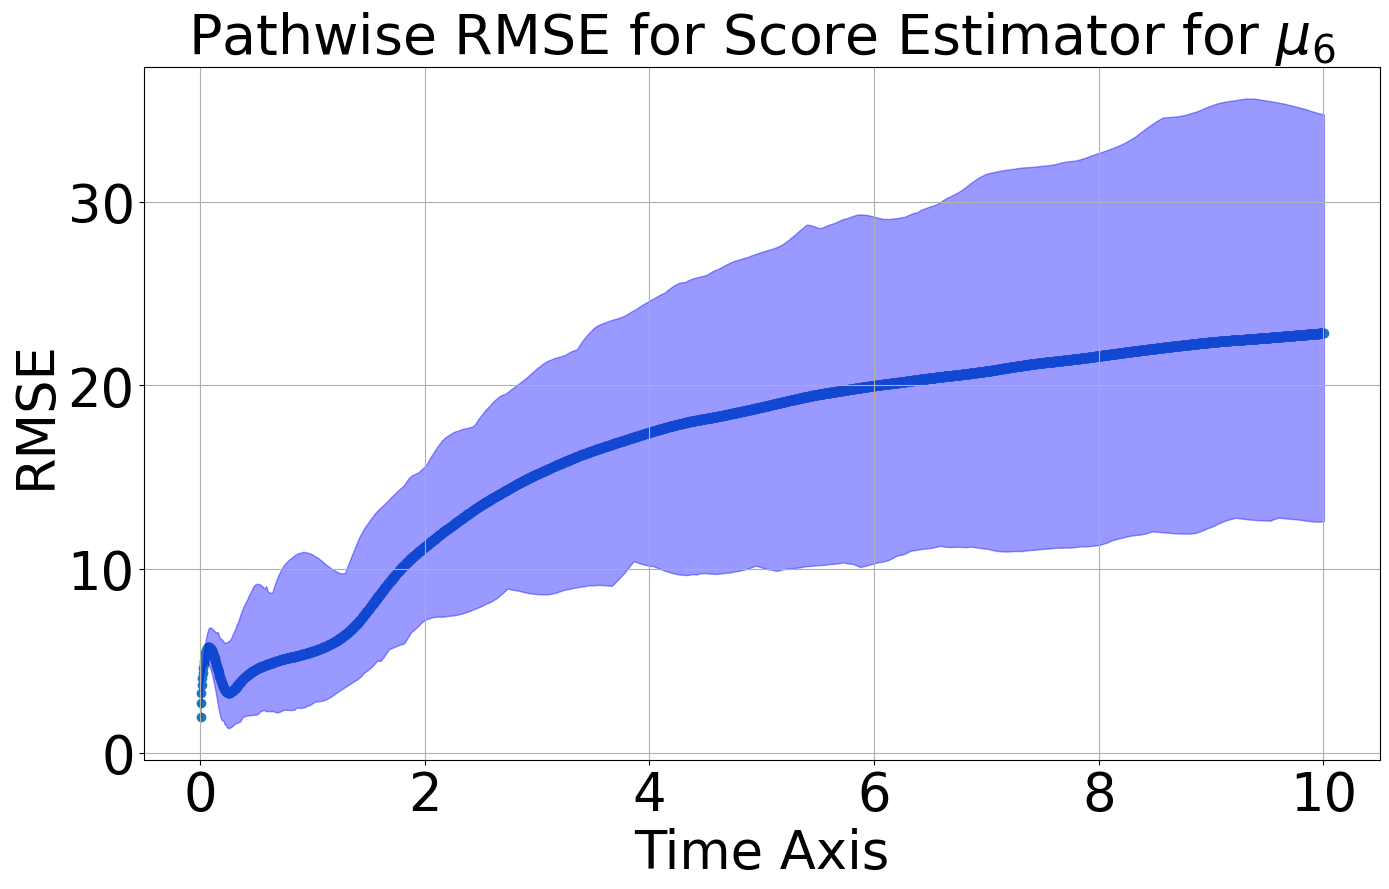

Final time cumulative MSE local-time error 22.836793576058785 with final IQR (12.604047691006713, 34.736312910393345) for 1.25FConst



In [20]:
import matplotlib.pyplot as plt
time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
all_global_errors = np.sum(np.power(all_true_states- all_global_states,2), axis=-1)
all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
total_local_errors[total_local_errors==np.inf] = 0.
all_paths_err[all_paths_err==np.inf] = 0.
total_local_errors_minq, total_local_errors_maxq  = np.quantile(all_paths_err, q=[0.005, 0.995], axis=0) # (T,)<
curr_rmse = total_local_errors[-1]
fig, ax = plt.subplots(figsize=(14,9))
plt.grid(True)
ax.scatter(time_steps, total_local_errors)
plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
ax.set_title(rf"Pathwise RMSE for Score Estimator for $\mu_5$",fontsize=40)
ax.set_ylabel("RMSE", fontsize=38)
ax.set_xlabel("Time Axis", fontsize=38)
ax.tick_params(labelsize=38)
plt.tight_layout()
plt.show()
plt.close()
print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with final IQR {(total_local_errors_minq[-1], total_local_errors_maxq[-1])} for {config.forcing_const}FConst\n")